In [2]:
!pip install mplcyberpunk

In [3]:
# Necessary Data Science Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mplcyberpunk

# ML models
import xgboost as xgb
import lightgbm as lgbm
import catboost

# sklearn
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import cohen_kappa_score

# ML utilities 
from category_encoders import LeaveOneOutEncoder
import optuna

# general purpose
import os
from pathlib import Path
from IPython.display import display
from tqdm.notebook import tqdm

In [4]:
# ignore the warnings to keep output cleaner
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
# makes it easy for access
BASE_PATH_COMP = Path("/kaggle/input/playground-series-s3e5")
BASE_PATH_ORG = Path("/kaggle/input/wine-quality-dataset")

train = pd.read_csv(BASE_PATH_COMP / "train.csv").drop(columns="Id")
test = pd.read_csv(BASE_PATH_COMP / "test.csv")
test_idx = test.Id
test.drop(columns="Id", inplace=True)

original = pd.read_csv(BASE_PATH_ORG / "WineQT.csv").drop(columns="Id")

In [6]:
pd.DataFrame([len(train), len(test), len(original)],
                 index=["Train", "Test", "Original"],
                 columns=["n_values"])

,n_values
Train,2056
Test,1372
Original,1143


In [7]:
train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,8.0,0.50,0.39,2.2,0.073,30.0,39.0,0.99572,3.33,0.77,12.1,6
1,9.3,0.30,0.73,2.3,0.092,30.0,67.0,0.99854,3.32,0.67,12.8,6
2,7.1,0.51,0.03,2.1,0.059,3.0,12.0,0.99660,3.52,0.73,11.3,7
3,8.1,0.87,0.22,2.6,0.084,11.0,65.0,0.99730,3.20,0.53,9.8,5
4,8.5,0.36,0.30,2.3,0.079,10.0,45.0,0.99444,3.20,1.36,9.5,6


### Checking for null values

In [8]:
pd.concat([train.isnull().sum().rename("Train Null"),
          test.isnull().sum().rename("Test Null")], axis=1)

,Train Null,Test Null
fixed acidity,0,0.0
volatile acidity,0,0.0
citric acid,0,0.0
residual sugar,0,0.0
chlorides,0,0.0
free sulfur dioxide,0,0.0
total sulfur dioxide,0,0.0
density,0,0.0
pH,0,0.0
sulphates,0,0.0


# Competition vs Original Dataset comparison

In [9]:
plt.style.use("cyberpunk")

### Let's plot the target distribution for competition and original data

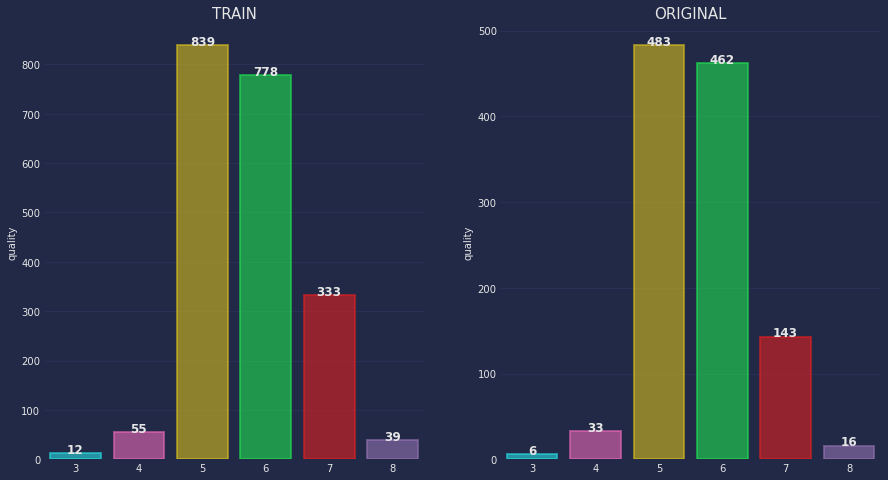

In [10]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))

for ax_counter, (df_name, df) in enumerate(zip(["train", "original"], [train, original])):
    counts = pd.DataFrame(df.quality.value_counts())
    _ = sns.barplot(x=counts.index, y=counts.quality, 
                    ax=axs[ax_counter], label=df_name,
                   alpha=0.6,linewidth=2)
#     print(len(axs[ax_counter].patches))
    for p in axs[ax_counter].patches:
        # setting the opacity to 100%
        edge_color = list(p.get_facecolor())
        edge_color[-1] = 1.0
#         print(edge_color)
#         break
        p.set_edgecolor(tuple(edge_color))
        axs[ax_counter].text(x=p.get_x()+(p.get_width()/2),
                            y=p.get_height(),
                            s=f"{round(p.get_height())}", ha="center",
                            fontsize=12,fontweight="bold")
    axs[ax_counter].set_title(f"{df_name.upper()}", fontsize=15,)

# Preprocessing

In [11]:
pd.concat([train.isnull().sum().rename("Missing in Train"),
          test.isnull().sum().rename("Missing in Test"),
          original.isnull().sum().rename("Missing in Original")], axis=1)

,Missing in Train,Missing in Test,Missing in Original
fixed acidity,0,0.0,0
volatile acidity,0,0.0,0
citric acid,0,0.0,0
residual sugar,0,0.0,0
chlorides,0,0.0,0
free sulfur dioxide,0,0.0,0
total sulfur dioxide,0,0.0,0
density,0,0.0,0
pH,0,0.0,0
sulphates,0,0.0,0


In [12]:
train.describe().T.style.background_gradient(cmap="Set2")\
                        .bar(subset=["mean"], color="limegreen")\
                        .background_gradient(subset=["std"], cmap="Reds")\
                        .background_gradient(subset=["min"], cmap="summer")\

,count,mean,std,min,25%,50%,75%,max
fixed acidity,2056.000000,8.365175,1.705390,5.000000,7.200000,7.950000,9.200000,15.900000
volatile acidity,2056.000000,0.527601,0.173164,0.180000,0.390000,0.520000,0.640000,1.580000
citric acid,2056.000000,0.265058,0.188267,0.000000,0.090000,0.250000,0.420000,0.760000
residual sugar,2056.000000,2.398881,0.858824,1.200000,1.900000,2.200000,2.600000,14.000000
chlorides,2056.000000,0.081856,0.023729,0.012000,0.071000,0.079000,0.090000,0.414000
free sulfur dioxide,2056.000000,16.955982,10.009710,1.000000,8.000000,16.000000,24.000000,68.000000
total sulfur dioxide,2056.000000,49.236868,32.961141,7.000000,22.000000,44.000000,65.000000,289.000000
density,2056.000000,0.996748,0.001827,0.990070,0.995600,0.996700,0.997800,1.003690
pH,2056.000000,3.310569,0.142321,2.740000,3.200000,3.310000,3.390000,3.780000
sulphates,2056.000000,0.641308,0.137942,0.390000,0.550000,0.610000,0.720000,1.950000


# Modelling

In [13]:
# train on combined i.e. comp + original dataset but evaluate only on comp dataset

def cross_validate(X, y, model, X_org, y_org):
    N_FOLDS = 5
    fold_scores = np.zeros(N_FOLDS)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # combining
        X_train = pd.concat([X_train, X_org], axis=0)
        y_train = pd.concat([y_train, y_org], axis=0)
        
        model.fit(X_train, y_train)
        
        y_preds = model.predict(X_val)
        
        score = cohen_kappa_score(y_val, y_preds, weights="quadratic")
        fold_scores[fold_id] = score
        print(f"FOLD #{fold_id}:\n\t Kappa Score: {score}")
    
    avg_score = np.mean(fold_scores)
    print(f"\n{'-'*15}AVG Kappa Score: {avg_score}{'-'*15}")

In [14]:
X, y = train.iloc[:, :-1], train.iloc[:, -1]
X_org, y_org = original.iloc[:, :-1], original.iloc[:, -1]

In [15]:
le = LabelEncoder()
y = pd.Series(le.fit_transform(y))
y_org = pd.Series(le.transform(y_org))

In [16]:
xgb_clf = xgb.XGBClassifier()
cross_validate(X, y, xgb_clf, X_org, y_org)

FOLD #0:
	 Kappa Score: 0.5402930753759219
FOLD #1:
	 Kappa Score: 0.5027844306977974
FOLD #2:
	 Kappa Score: 0.44546229228802725
FOLD #3:
	 Kappa Score: 0.46590606773764454
FOLD #4:
	 Kappa Score: 0.4702200332030956

---------------AVG Kappa Score: 0.4849331798604973---------------


# Tuning XGBoost

In [ ]:
def objective_xgb(trial, X, y, X_org, y_org):
    params = {
        "tree_method": "gpu_hist",
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 0.00001, 0.5),
        'subsample': trial.suggest_loguniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.00001, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.00001, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 100)
    }
    N_FOLDS = 5
    fold_scores = np.zeros(N_FOLDS)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        
        # combining
        X_train = pd.concat([X_train, X_org], axis=0)
        y_train = pd.concat([y_train, y_org], axis=0)
        
        model = xgb.XGBClassifier(**params)
        model.fit(X_train, y_train, 
                  eval_metric="mlogloss", eval_set=[(X_val, y_val)],
                 verbose=False)
        
        y_preds = model.predict(X_val)
        
        score = cohen_kappa_score(y_val, y_preds, weights="quadratic")
        fold_scores[fold_id] = score
#         print(f"FOLD #{fold_id}:\n\t Kappa Score: {score}")
    
    avg_score = np.mean(fold_scores)
    print(f"\n{'-'*15}AVG Kappa Score: {avg_score}{'-'*15}")
    
    return avg_score
    

In [ ]:
xgb_study = optuna.create_study(study_name="xgboost_tuning", direction="maximize")
func = lambda trial: objective_xgb(trial, X, y, X_org, y_org)
xgb_study.optimize(func, n_trials=100)

In [ ]:
print(f"BEST_VALUE: {xgb_study.best_value}\n\tBEST_PARAMS:\n{xgb_study.best_params}")

# Let's tune XGBoost with portaying this problem as a regression instead of multiclass

In [42]:
min(y), max(y)

(0, 5)

In [52]:
def objective_xgb_reg(trial, X, y, X_org, y_org):
    params = {
        "tree_method": "gpu_hist",
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.0001, 0.5),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 0.00001, 3),
        'subsample': trial.suggest_loguniform('subsample', 0.2, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.2, 1.0),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 0.00001, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 0.00001, 1.0),
        'early_stopping_rounds': trial.suggest_int('early_stopping_rounds', 50, 100)
    }
    N_FOLDS = 5
    fold_scores = np.zeros(N_FOLDS)
    skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=1337)
    
    for fold_id, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]
        y_val = y_val.astype("float32")
        
        # combining
        X_train = pd.concat([X_train, X_org], axis=0)
        y_train = pd.concat([y_train, y_org], axis=0).astype("float32")
        
        model = xgb.XGBRegressor(**params)
        model.fit(X_train, y_train, 
                  eval_metric="rmse", eval_set=[(X_val, y_val)],
                 verbose=False)
        
        y_preds = model.predict(X_val)
        y_preds = y_preds.round().clip(min(y_train), max(y_train))
        
#         print(y_val)
#         print(y_preds)
        
        score = cohen_kappa_score(y_val, y_preds, weights="quadratic")
        fold_scores[fold_id] = score
#         print(f"FOLD #{fold_id}:\n\t Kappa Score: {score}")
    
    avg_score = np.mean(fold_scores)
    print(f"\n{'-'*15}AVG Kappa Score: {avg_score}{'-'*15}")
    
    return avg_score

In [53]:
xgb_reg_study = optuna.create_study(study_name="xgboost_tuning", direction="maximize")
func = lambda trial: objective_xgb_reg(trial, X, y, X_org, y_org)
xgb_reg_study.optimize(func, n_trials=100)

[I 2023-02-03 12:39:24,940] A new study created in memory with name: xgboost_tuning
[I 2023-02-03 12:39:28,362] Trial 0 finished with value: 0.48282393459805173 and parameters: {'n_estimators': 280, 'max_depth': 7, 'learning_rate': 0.05282127402964367, 'min_child_weight': 2, 'gamma': 0.00014716355450849236, 'subsample': 0.2686358078328238, 'colsample_bytree': 0.5292488176460711, 'reg_alpha': 0.00031535386191637095, 'reg_lambda': 0.001457505468419961, 'early_stopping_rounds': 72}. Best is trial 0 with value: 0.48282393459805173.



---------------AVG Kappa Score: 0.48282393459805173---------------


[I 2023-02-03 12:39:45,025] Trial 1 finished with value: 0.1772264706464968 and parameters: {'n_estimators': 389, 'max_depth': 8, 'learning_rate': 0.0020068703333478636, 'min_child_weight': 3, 'gamma': 0.07048804468901566, 'subsample': 0.5912419701840586, 'colsample_bytree': 0.8250469909686049, 'reg_alpha': 1.8238405131244003e-05, 'reg_lambda': 0.015679905539857875, 'early_stopping_rounds': 62}. Best is trial 0 with value: 0.48282393459805173.



---------------AVG Kappa Score: 0.1772264706464968---------------


[I 2023-02-03 12:39:46,009] Trial 2 finished with value: 0.0 and parameters: {'n_estimators': 114, 'max_depth': 4, 'learning_rate': 0.002278745136577225, 'min_child_weight': 4, 'gamma': 0.11804710162796414, 'subsample': 0.2905802611117532, 'colsample_bytree': 0.3762529007994904, 'reg_alpha': 0.07746164727824309, 'reg_lambda': 8.121795918414802e-05, 'early_stopping_rounds': 84}. Best is trial 0 with value: 0.48282393459805173.



---------------AVG Kappa Score: 0.0---------------


[I 2023-02-03 12:39:46,805] Trial 3 finished with value: 0.0 and parameters: {'n_estimators': 116, 'max_depth': 3, 'learning_rate': 0.0002571429253712605, 'min_child_weight': 7, 'gamma': 0.02621243578641925, 'subsample': 0.6658753374077439, 'colsample_bytree': 0.5367120835482566, 'reg_alpha': 0.38449311602762637, 'reg_lambda': 0.00039172382233044995, 'early_stopping_rounds': 95}. Best is trial 0 with value: 0.48282393459805173.



---------------AVG Kappa Score: 0.0---------------


[I 2023-02-03 12:39:47,942] Trial 4 finished with value: 0.48520431529956876 and parameters: {'n_estimators': 428, 'max_depth': 5, 'learning_rate': 0.09624162410112753, 'min_child_weight': 6, 'gamma': 0.41812418826876513, 'subsample': 0.898794704700756, 'colsample_bytree': 0.8631791142062836, 'reg_alpha': 0.0003799955302373066, 'reg_lambda': 0.0002898799043668644, 'early_stopping_rounds': 52}. Best is trial 4 with value: 0.48520431529956876.



---------------AVG Kappa Score: 0.48520431529956876---------------


[I 2023-02-03 12:39:51,376] Trial 5 finished with value: 0.4722148977559838 and parameters: {'n_estimators': 385, 'max_depth': 7, 'learning_rate': 0.15091801159878815, 'min_child_weight': 1, 'gamma': 0.0003761745770728352, 'subsample': 0.717850473994719, 'colsample_bytree': 0.7278288999243303, 'reg_alpha': 4.068453329743769e-05, 'reg_lambda': 2.267538569384752e-05, 'early_stopping_rounds': 91}. Best is trial 4 with value: 0.48520431529956876.



---------------AVG Kappa Score: 0.4722148977559838---------------


[I 2023-02-03 12:39:52,345] Trial 6 finished with value: 0.48461596433392395 and parameters: {'n_estimators': 74, 'max_depth': 7, 'learning_rate': 0.04854711272635331, 'min_child_weight': 10, 'gamma': 0.004243582811439538, 'subsample': 0.209397606464766, 'colsample_bytree': 0.4603279592132417, 'reg_alpha': 0.9900043354094844, 'reg_lambda': 0.6085700457638737, 'early_stopping_rounds': 74}. Best is trial 4 with value: 0.48520431529956876.



---------------AVG Kappa Score: 0.48461596433392395---------------


[I 2023-02-03 12:40:01,045] Trial 7 finished with value: 0.20408033362826364 and parameters: {'n_estimators': 232, 'max_depth': 10, 'learning_rate': 0.0061374953484951205, 'min_child_weight': 8, 'gamma': 0.7549138218883344, 'subsample': 0.849756969797522, 'colsample_bytree': 0.419876718048769, 'reg_alpha': 1.2612216713452926e-05, 'reg_lambda': 1.6588632840584435e-05, 'early_stopping_rounds': 76}. Best is trial 4 with value: 0.48520431529956876.



---------------AVG Kappa Score: 0.20408033362826364---------------


[I 2023-02-03 12:40:13,844] Trial 8 finished with value: 0.11835474136588842 and parameters: {'n_estimators': 429, 'max_depth': 9, 'learning_rate': 0.0024706113577565828, 'min_child_weight': 7, 'gamma': 0.00011710627642063866, 'subsample': 0.2653331882019643, 'colsample_bytree': 0.8622086676122792, 'reg_alpha': 0.011938912179055223, 'reg_lambda': 4.8543738826070696e-05, 'early_stopping_rounds': 70}. Best is trial 4 with value: 0.48520431529956876.



---------------AVG Kappa Score: 0.11835474136588842---------------


[I 2023-02-03 12:40:14,764] Trial 9 finished with value: 0.4959458785377711 and parameters: {'n_estimators': 213, 'max_depth': 1, 'learning_rate': 0.36549333466224787, 'min_child_weight': 7, 'gamma': 4.738467185289235e-05, 'subsample': 0.5745441154706074, 'colsample_bytree': 0.22578077538232502, 'reg_alpha': 5.991361826406108e-05, 'reg_lambda': 0.011566858068866441, 'early_stopping_rounds': 94}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.4959458785377711---------------


[I 2023-02-03 12:40:15,716] Trial 10 finished with value: 0.48373910032539913 and parameters: {'n_estimators': 235, 'max_depth': 1, 'learning_rate': 0.48534311705049343, 'min_child_weight': 10, 'gamma': 1.2676758977020741e-05, 'subsample': 0.45002972429650806, 'colsample_bytree': 0.22687733678771788, 'reg_alpha': 0.0011943151712721734, 'reg_lambda': 0.01506385281720155, 'early_stopping_rounds': 99}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.48373910032539913---------------


[I 2023-02-03 12:40:16,672] Trial 11 finished with value: 0.48835856064315486 and parameters: {'n_estimators': 499, 'max_depth': 1, 'learning_rate': 0.4018150184094269, 'min_child_weight': 5, 'gamma': 2.8864916999472796, 'subsample': 0.9761244879137528, 'colsample_bytree': 0.20370787783532446, 'reg_alpha': 0.00024144407191667636, 'reg_lambda': 0.000515075223828244, 'early_stopping_rounds': 51}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.48835856064315486---------------


[I 2023-02-03 12:40:17,272] Trial 12 finished with value: 0.48160932990517163 and parameters: {'n_estimators': 494, 'max_depth': 1, 'learning_rate': 0.37534479087534794, 'min_child_weight': 5, 'gamma': 2.7378014669552475, 'subsample': 0.9710867101485415, 'colsample_bytree': 0.21326692417494836, 'reg_alpha': 0.00012225733596483805, 'reg_lambda': 0.005327815372232573, 'early_stopping_rounds': 51}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.48160932990517163---------------


[I 2023-02-03 12:40:18,980] Trial 13 finished with value: 0.48830571049653637 and parameters: {'n_estimators': 306, 'max_depth': 2, 'learning_rate': 0.027786871814858168, 'min_child_weight': 5, 'gamma': 0.003942299639830563, 'subsample': 0.5439749752301953, 'colsample_bytree': 0.27298103660049, 'reg_alpha': 8.817976244683358e-05, 'reg_lambda': 0.0018603277786237511, 'early_stopping_rounds': 84}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.48830571049653637---------------


[I 2023-02-03 12:40:19,809] Trial 14 finished with value: 0.49042889426305003 and parameters: {'n_estimators': 191, 'max_depth': 3, 'learning_rate': 0.22303160194401184, 'min_child_weight': 8, 'gamma': 0.0012148327507440235, 'subsample': 0.7648996406978608, 'colsample_bytree': 0.20236889999857924, 'reg_alpha': 0.0025629534080760645, 'reg_lambda': 0.0677917783641713, 'early_stopping_rounds': 60}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.49042889426305003---------------


[I 2023-02-03 12:40:20,600] Trial 15 finished with value: 0.4894963081213975 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.20119295670032278, 'min_child_weight': 8, 'gamma': 0.0009885598079716327, 'subsample': 0.46519975404788044, 'colsample_bytree': 0.27866486481334934, 'reg_alpha': 0.0030148325899020884, 'reg_lambda': 0.09541209440983622, 'early_stopping_rounds': 59}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.4894963081213975---------------


[I 2023-02-03 12:40:21,850] Trial 16 finished with value: 0.4505835108811295 and parameters: {'n_estimators': 181, 'max_depth': 3, 'learning_rate': 0.02187501336051782, 'min_child_weight': 9, 'gamma': 1.3696809934388997e-05, 'subsample': 0.7366783302698171, 'colsample_bytree': 0.2930842946069773, 'reg_alpha': 0.012871300512777017, 'reg_lambda': 0.07597554871649231, 'early_stopping_rounds': 63}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.4505835108811295---------------


[I 2023-02-03 12:40:23,313] Trial 17 finished with value: 0.4842956580307082 and parameters: {'n_estimators': 323, 'max_depth': 5, 'learning_rate': 0.1301778236125123, 'min_child_weight': 8, 'gamma': 5.163060893153798e-05, 'subsample': 0.5555181876277504, 'colsample_bytree': 0.24632356803360309, 'reg_alpha': 0.001088265588603102, 'reg_lambda': 0.7393619224262079, 'early_stopping_rounds': 83}. Best is trial 9 with value: 0.4959458785377711.



---------------AVG Kappa Score: 0.4842956580307082---------------


[I 2023-02-03 12:40:24,197] Trial 18 finished with value: 0.4995532777005457 and parameters: {'n_estimators': 180, 'max_depth': 2, 'learning_rate': 0.17204086643494862, 'min_child_weight': 7, 'gamma': 0.0011238084314844528, 'subsample': 0.7715663805700768, 'colsample_bytree': 0.2051918947119489, 'reg_alpha': 4.165412761721107e-05, 'reg_lambda': 0.08067349372105619, 'early_stopping_rounds': 66}. Best is trial 18 with value: 0.4995532777005457.



---------------AVG Kappa Score: 0.4995532777005457---------------


[I 2023-02-03 12:40:25,028] Trial 19 finished with value: 0.4927638416625566 and parameters: {'n_estimators': 138, 'max_depth': 2, 'learning_rate': 0.06733885586526003, 'min_child_weight': 6, 'gamma': 5.046465454161793e-05, 'subsample': 0.6255620640525282, 'colsample_bytree': 0.32872177498645827, 'reg_alpha': 3.45917369679786e-05, 'reg_lambda': 0.007085684585045438, 'early_stopping_rounds': 90}. Best is trial 18 with value: 0.4995532777005457.



---------------AVG Kappa Score: 0.4927638416625566---------------


[I 2023-02-03 12:40:26,444] Trial 20 finished with value: 0.42393527473683373 and parameters: {'n_estimators': 241, 'max_depth': 2, 'learning_rate': 0.020917857101208578, 'min_child_weight': 7, 'gamma': 0.0007398254089650916, 'subsample': 0.8120566517639941, 'colsample_bytree': 0.24848010512876834, 'reg_alpha': 1.2970164367683356e-05, 'reg_lambda': 0.03215644449291844, 'early_stopping_rounds': 68}. Best is trial 18 with value: 0.4995532777005457.



---------------AVG Kappa Score: 0.42393527473683373---------------


[I 2023-02-03 12:40:27,493] Trial 21 finished with value: 0.5017095123589066 and parameters: {'n_estimators': 138, 'max_depth': 2, 'learning_rate': 0.09866463433909427, 'min_child_weight': 6, 'gamma': 4.697218379151282e-05, 'subsample': 0.6581493939808085, 'colsample_bytree': 0.30456359127645083, 'reg_alpha': 4.8717112450312945e-05, 'reg_lambda': 0.0069691554318123666, 'early_stopping_rounds': 91}. Best is trial 21 with value: 0.5017095123589066.



---------------AVG Kappa Score: 0.5017095123589066---------------


[I 2023-02-03 12:40:28,001] Trial 22 finished with value: 0.4820346115802243 and parameters: {'n_estimators': 53, 'max_depth': 4, 'learning_rate': 0.21640460766887243, 'min_child_weight': 6, 'gamma': 0.00024231379718046768, 'subsample': 0.6732046868527457, 'colsample_bytree': 0.24477725842999737, 'reg_alpha': 3.5980968474932836e-05, 'reg_lambda': 0.00448827503820034, 'early_stopping_rounds': 100}. Best is trial 21 with value: 0.5017095123589066.



---------------AVG Kappa Score: 0.4820346115802243---------------


[I 2023-02-03 12:40:28,773] Trial 23 finished with value: 0.48548729187291784 and parameters: {'n_estimators': 150, 'max_depth': 1, 'learning_rate': 0.10777933474413738, 'min_child_weight': 4, 'gamma': 5.648172450140826e-05, 'subsample': 0.5168043038942579, 'colsample_bytree': 0.3055567603225884, 'reg_alpha': 0.00012565056933147668, 'reg_lambda': 0.19511459859219699, 'early_stopping_rounds': 79}. Best is trial 21 with value: 0.5017095123589066.



---------------AVG Kappa Score: 0.48548729187291784---------------


[I 2023-02-03 12:40:29,551] Trial 24 finished with value: 0.4980047261547126 and parameters: {'n_estimators': 212, 'max_depth': 2, 'learning_rate': 0.4519004609832657, 'min_child_weight': 7, 'gamma': 2.0844926416390984e-05, 'subsample': 0.626271897479148, 'colsample_bytree': 0.23046211191041896, 'reg_alpha': 4.8716826483318076e-05, 'reg_lambda': 0.017326831472665876, 'early_stopping_rounds': 91}. Best is trial 21 with value: 0.5017095123589066.



---------------AVG Kappa Score: 0.4980047261547126---------------


[I 2023-02-03 12:40:30,595] Trial 25 finished with value: 0.5094765219380181 and parameters: {'n_estimators': 150, 'max_depth': 4, 'learning_rate': 0.2287442951590344, 'min_child_weight': 9, 'gamma': 2.466429687147407e-05, 'subsample': 0.7484517088637556, 'colsample_bytree': 0.25913119759243913, 'reg_alpha': 1.840737996862226e-05, 'reg_lambda': 0.027158531231378884, 'early_stopping_rounds': 88}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5094765219380181---------------


[I 2023-02-03 12:40:31,507] Trial 26 finished with value: 0.48614636417795626 and parameters: {'n_estimators': 95, 'max_depth': 4, 'learning_rate': 0.08187981957653159, 'min_child_weight': 9, 'gamma': 0.00031720668440856514, 'subsample': 0.8069232803704476, 'colsample_bytree': 0.3237377394742486, 'reg_alpha': 1.1275421384886096e-05, 'reg_lambda': 0.030866040574421962, 'early_stopping_rounds': 87}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48614636417795626---------------


[I 2023-02-03 12:40:33,140] Trial 27 finished with value: 0.4827055590464104 and parameters: {'n_estimators': 142, 'max_depth': 6, 'learning_rate': 0.16548957441642057, 'min_child_weight': 9, 'gamma': 2.5065876102097138e-05, 'subsample': 0.725353989073717, 'colsample_bytree': 0.2735517319119779, 'reg_alpha': 3.061232787986292e-05, 'reg_lambda': 0.24735075379653435, 'early_stopping_rounds': 81}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4827055590464104---------------


[I 2023-02-03 12:40:34,526] Trial 28 finished with value: 0.4744226630934654 and parameters: {'n_estimators': 164, 'max_depth': 4, 'learning_rate': 0.03322003599439643, 'min_child_weight': 9, 'gamma': 9.494407048609399e-05, 'subsample': 0.9080481748700648, 'colsample_bytree': 0.3426873386182652, 'reg_alpha': 0.00017721187098970227, 'reg_lambda': 0.03574760012649633, 'early_stopping_rounds': 66}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4744226630934654---------------


[I 2023-02-03 12:40:38,159] Trial 29 finished with value: 0.4908753231892766 and parameters: {'n_estimators': 276, 'max_depth': 6, 'learning_rate': 0.051488195102208395, 'min_child_weight': 4, 'gamma': 0.00020054084136752958, 'subsample': 0.8089432491060224, 'colsample_bytree': 0.2003139625521564, 'reg_alpha': 0.00042517962307212236, 'reg_lambda': 0.0025709283010157858, 'early_stopping_rounds': 79}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4908753231892766---------------


[I 2023-02-03 12:40:39,699] Trial 30 finished with value: 0.4706292657790824 and parameters: {'n_estimators': 115, 'max_depth': 5, 'learning_rate': 0.055769499612630835, 'min_child_weight': 10, 'gamma': 1.0151370759807873e-05, 'subsample': 0.6824200008530895, 'colsample_bytree': 0.2618311714248647, 'reg_alpha': 9.515293290114293e-05, 'reg_lambda': 0.006895360491507167, 'early_stopping_rounds': 56}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4706292657790824---------------


[I 2023-02-03 12:40:40,669] Trial 31 finished with value: 0.502718341315466 and parameters: {'n_estimators': 206, 'max_depth': 2, 'learning_rate': 0.2152764940816012, 'min_child_weight': 6, 'gamma': 0.00011435167153230626, 'subsample': 0.6508831961039121, 'colsample_bytree': 0.22681250739279868, 'reg_alpha': 2.4649855116636904e-05, 'reg_lambda': 0.0192573239242422, 'early_stopping_rounds': 89}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.502718341315466---------------


[I 2023-02-03 12:40:41,567] Trial 32 finished with value: 0.49612791675649454 and parameters: {'n_estimators': 255, 'max_depth': 2, 'learning_rate': 0.24820675829394226, 'min_child_weight': 6, 'gamma': 0.00015435722660475713, 'subsample': 0.6218809852526277, 'colsample_bytree': 0.23118892166291224, 'reg_alpha': 2.2175983479110433e-05, 'reg_lambda': 0.0026791022439754918, 'early_stopping_rounds': 87}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49612791675649454---------------


[I 2023-02-03 12:40:42,907] Trial 33 finished with value: 0.5072753633452816 and parameters: {'n_estimators': 207, 'max_depth': 3, 'learning_rate': 0.09967631617439157, 'min_child_weight': 2, 'gamma': 2.7296194138621158e-05, 'subsample': 0.4973651894672116, 'colsample_bytree': 0.2568724286520038, 'reg_alpha': 1.9962192979729496e-05, 'reg_lambda': 0.009287822857793294, 'early_stopping_rounds': 95}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5072753633452816---------------


[I 2023-02-03 12:40:44,029] Trial 34 finished with value: 0.49393673822372375 and parameters: {'n_estimators': 302, 'max_depth': 3, 'learning_rate': 0.11697407913587866, 'min_child_weight': 2, 'gamma': 2.386046882875071e-05, 'subsample': 0.4929502512023669, 'colsample_bytree': 0.2908013337840256, 'reg_alpha': 1.870063009108534e-05, 'reg_lambda': 0.001186232737498419, 'early_stopping_rounds': 96}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49393673822372375---------------


[I 2023-02-03 12:40:45,615] Trial 35 finished with value: 0.4873227247794204 and parameters: {'n_estimators': 204, 'max_depth': 4, 'learning_rate': 0.07436635683503404, 'min_child_weight': 3, 'gamma': 9.14290383263854e-05, 'subsample': 0.4037740071732157, 'colsample_bytree': 0.2565763701377674, 'reg_alpha': 1.071578555594194e-05, 'reg_lambda': 0.010007256768820942, 'early_stopping_rounds': 88}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4873227247794204---------------


[I 2023-02-03 12:40:46,307] Trial 36 finished with value: 0.0 and parameters: {'n_estimators': 89, 'max_depth': 3, 'learning_rate': 0.012128489478623753, 'min_child_weight': 1, 'gamma': 2.8236235200801427e-05, 'subsample': 0.5955447483863854, 'colsample_bytree': 0.351186771739562, 'reg_alpha': 2.2124989672015336e-05, 'reg_lambda': 0.0038582454959611694, 'early_stopping_rounds': 94}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.0---------------


[I 2023-02-03 12:40:47,762] Trial 37 finished with value: 0.49011405210617376 and parameters: {'n_estimators': 126, 'max_depth': 5, 'learning_rate': 0.09894899729952444, 'min_child_weight': 3, 'gamma': 1.0679120435098252e-05, 'subsample': 0.6790328415760415, 'colsample_bytree': 0.3116142647012387, 'reg_alpha': 7.192093035871188e-05, 'reg_lambda': 0.01899639868858819, 'early_stopping_rounds': 96}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49011405210617376---------------


[I 2023-02-03 12:40:49,049] Trial 38 finished with value: 0.4841601122809821 and parameters: {'n_estimators': 160, 'max_depth': 3, 'learning_rate': 0.03802709153441737, 'min_child_weight': 2, 'gamma': 8.494435083534471e-05, 'subsample': 0.40635193116018525, 'colsample_bytree': 0.3718289451246721, 'reg_alpha': 2.107509595905398e-05, 'reg_lambda': 0.0011446376731139194, 'early_stopping_rounds': 90}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4841601122809821---------------


[I 2023-02-03 12:40:50,220] Trial 39 finished with value: 0.4862875830292728 and parameters: {'n_estimators': 340, 'max_depth': 4, 'learning_rate': 0.2629241364706986, 'min_child_weight': 4, 'gamma': 3.279127356996017e-05, 'subsample': 0.5275305501968272, 'colsample_bytree': 0.2979687538682419, 'reg_alpha': 1.0076378360271378e-05, 'reg_lambda': 0.009793706595128645, 'early_stopping_rounds': 98}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4862875830292728---------------


[I 2023-02-03 12:40:53,359] Trial 40 finished with value: 0.4793085519336504 and parameters: {'n_estimators': 266, 'max_depth': 8, 'learning_rate': 0.13397937655610903, 'min_child_weight': 5, 'gamma': 0.00015536455085924097, 'subsample': 0.5774088840705219, 'colsample_bytree': 0.267064238851567, 'reg_alpha': 5.293100675098588e-05, 'reg_lambda': 0.028171039657699876, 'early_stopping_rounds': 93}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4793085519336504---------------


[I 2023-02-03 12:40:54,294] Trial 41 finished with value: 0.501690971016835 and parameters: {'n_estimators': 171, 'max_depth': 2, 'learning_rate': 0.162097495049988, 'min_child_weight': 6, 'gamma': 0.00041771646154362027, 'subsample': 0.7525992948741823, 'colsample_bytree': 0.22009492028903138, 'reg_alpha': 3.5658285328622664e-05, 'reg_lambda': 0.045768919147571564, 'early_stopping_rounds': 75}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.501690971016835---------------


[I 2023-02-03 12:40:55,504] Trial 42 finished with value: 0.48762757399405937 and parameters: {'n_estimators': 220, 'max_depth': 2, 'learning_rate': 0.07410515098333467, 'min_child_weight': 6, 'gamma': 0.0004830150789101106, 'subsample': 0.8692986770250596, 'colsample_bytree': 0.2245978048661184, 'reg_alpha': 2.521931070314893e-05, 'reg_lambda': 0.019825518099912585, 'early_stopping_rounds': 76}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48762757399405937---------------


[I 2023-02-03 12:40:56,124] Trial 43 finished with value: 0.49000820553233987 and parameters: {'n_estimators': 99, 'max_depth': 2, 'learning_rate': 0.3059549896829134, 'min_child_weight': 6, 'gamma': 8.303293781193807e-05, 'subsample': 0.7143045940166113, 'colsample_bytree': 0.25181699629294624, 'reg_alpha': 6.685001486549298e-05, 'reg_lambda': 0.011117356067974022, 'early_stopping_rounds': 74}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49000820553233987---------------


[I 2023-02-03 12:40:56,940] Trial 44 finished with value: 0.4872144445969294 and parameters: {'n_estimators': 163, 'max_depth': 1, 'learning_rate': 0.2997168539217171, 'min_child_weight': 5, 'gamma': 4.4482824149968016e-05, 'subsample': 0.6443448965916061, 'colsample_bytree': 0.2362326493979867, 'reg_alpha': 1.736950027861036e-05, 'reg_lambda': 0.00691504096912515, 'early_stopping_rounds': 85}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4872144445969294---------------


[I 2023-02-03 12:40:58,050] Trial 45 finished with value: 0.4986454567558557 and parameters: {'n_estimators': 194, 'max_depth': 3, 'learning_rate': 0.17816651180937193, 'min_child_weight': 3, 'gamma': 1.8627994900090948e-05, 'subsample': 0.5936365335428192, 'colsample_bytree': 0.2154375993390917, 'reg_alpha': 0.0001665880322386123, 'reg_lambda': 0.038696060782445696, 'early_stopping_rounds': 71}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4986454567558557---------------


[I 2023-02-03 12:40:58,722] Trial 46 finished with value: 0.48232517085939064 and parameters: {'n_estimators': 124, 'max_depth': 1, 'learning_rate': 0.1239343876110184, 'min_child_weight': 4, 'gamma': 0.00024027053297958473, 'subsample': 0.6987934467398558, 'colsample_bytree': 0.21845089901459439, 'reg_alpha': 7.214399851834928e-05, 'reg_lambda': 0.053080039286640485, 'early_stopping_rounds': 92}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48232517085939064---------------


[I 2023-02-03 12:40:59,365] Trial 47 finished with value: 0.4820767934422749 and parameters: {'n_estimators': 69, 'max_depth': 4, 'learning_rate': 0.3274561141490845, 'min_child_weight': 8, 'gamma': 0.00011951470822826612, 'subsample': 0.771593240803936, 'colsample_bytree': 0.28258765692632964, 'reg_alpha': 3.057162851752994e-05, 'reg_lambda': 0.019834205331701635, 'early_stopping_rounds': 97}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4820767934422749---------------


[I 2023-02-03 12:41:00,305] Trial 48 finished with value: 0.48015880209785244 and parameters: {'n_estimators': 230, 'max_depth': 3, 'learning_rate': 0.4538722857386037, 'min_child_weight': 5, 'gamma': 4.411360177237973e-05, 'subsample': 0.8971827426884872, 'colsample_bytree': 0.24244581343277047, 'reg_alpha': 0.0003031222002478282, 'reg_lambda': 0.012684554009038026, 'early_stopping_rounds': 79}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48015880209785244---------------


[I 2023-02-03 12:41:01,352] Trial 49 finished with value: 0.4959263246919914 and parameters: {'n_estimators': 178, 'max_depth': 2, 'learning_rate': 0.09082183314044805, 'min_child_weight': 1, 'gamma': 0.0005087708125808135, 'subsample': 0.6402828509331233, 'colsample_bytree': 0.26823134422383, 'reg_alpha': 1.6423445272709737e-05, 'reg_lambda': 0.12681010888787886, 'early_stopping_rounds': 88}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4959263246919914---------------


[I 2023-02-03 12:41:02,332] Trial 50 finished with value: 0.4804035780829147 and parameters: {'n_estimators': 245, 'max_depth': 3, 'learning_rate': 0.2192622019326082, 'min_child_weight': 6, 'gamma': 1.8679912914872887e-05, 'subsample': 0.8464324451219137, 'colsample_bytree': 0.2224637696712745, 'reg_alpha': 4.3120503229368157e-05, 'reg_lambda': 0.049456323973612756, 'early_stopping_rounds': 82}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4804035780829147---------------


[I 2023-02-03 12:41:03,230] Trial 51 finished with value: 0.49130819178689594 and parameters: {'n_estimators': 182, 'max_depth': 2, 'learning_rate': 0.18311151106610252, 'min_child_weight': 7, 'gamma': 0.002673309747968489, 'subsample': 0.7470737903884319, 'colsample_bytree': 0.2095272132517369, 'reg_alpha': 4.702147994886928e-05, 'reg_lambda': 0.07327966646810918, 'early_stopping_rounds': 65}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49130819178689594---------------


[I 2023-02-03 12:41:04,209] Trial 52 finished with value: 0.48969552032195607 and parameters: {'n_estimators': 200, 'max_depth': 1, 'learning_rate': 0.15106302296754434, 'min_child_weight': 7, 'gamma': 0.0002544739975679773, 'subsample': 0.7573369383032031, 'colsample_bytree': 0.21075772147934668, 'reg_alpha': 0.00011104510448665988, 'reg_lambda': 0.023561264680011983, 'early_stopping_rounds': 72}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48969552032195607---------------


[I 2023-02-03 12:41:05,132] Trial 53 finished with value: 0.4650804602935753 and parameters: {'n_estimators': 145, 'max_depth': 2, 'learning_rate': 0.04428037997492154, 'min_child_weight': 7, 'gamma': 0.0015425657051037903, 'subsample': 0.6790796480369223, 'colsample_bytree': 0.23751673340470777, 'reg_alpha': 2.897619043792508e-05, 'reg_lambda': 0.045630021672735714, 'early_stopping_rounds': 77}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4650804602935753---------------


[I 2023-02-03 12:41:06,017] Trial 54 finished with value: 0.4623069840167552 and parameters: {'n_estimators': 171, 'max_depth': 1, 'learning_rate': 0.06198778413002929, 'min_child_weight': 8, 'gamma': 0.0005764222014488183, 'subsample': 0.7940530694054353, 'colsample_bytree': 0.2571563914572223, 'reg_alpha': 1.6732068071722038e-05, 'reg_lambda': 0.005398119007116364, 'early_stopping_rounds': 69}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4623069840167552---------------


[I 2023-02-03 12:41:06,834] Trial 55 finished with value: 0.48402552222028367 and parameters: {'n_estimators': 132, 'max_depth': 3, 'learning_rate': 0.15671621090818125, 'min_child_weight': 6, 'gamma': 0.0001594942855766602, 'subsample': 0.7158120185716561, 'colsample_bytree': 0.20175394984710482, 'reg_alpha': 4.34148162725219e-05, 'reg_lambda': 0.1188996508314065, 'early_stopping_rounds': 55}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48402552222028367---------------


[I 2023-02-03 12:41:09,304] Trial 56 finished with value: 0.4198692803869086 and parameters: {'n_estimators': 153, 'max_depth': 10, 'learning_rate': 0.27689085127204555, 'min_child_weight': 5, 'gamma': 0.0003871930725262145, 'subsample': 0.9880697841687257, 'colsample_bytree': 0.21928584669541365, 'reg_alpha': 7.508939646619204e-05, 'reg_lambda': 0.012229020514423879, 'early_stopping_rounds': 85}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4198692803869086---------------


[I 2023-02-03 12:41:11,063] Trial 57 finished with value: 0.4994060409603899 and parameters: {'n_estimators': 222, 'max_depth': 2, 'learning_rate': 0.11542854620166224, 'min_child_weight': 7, 'gamma': 0.011847279585340188, 'subsample': 0.6552904949985641, 'colsample_bytree': 0.2346140383850476, 'reg_alpha': 1.343232264943774e-05, 'reg_lambda': 0.024692388194420132, 'early_stopping_rounds': 90}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4994060409603899---------------


[I 2023-02-03 12:41:11,787] Trial 58 finished with value: 0.4820479493959696 and parameters: {'n_estimators': 102, 'max_depth': 3, 'learning_rate': 0.4856599452161058, 'min_child_weight': 6, 'gamma': 7.170447999947752e-05, 'subsample': 0.5573911173503269, 'colsample_bytree': 0.28161511912750486, 'reg_alpha': 3.089139376022307e-05, 'reg_lambda': 0.05811557370956674, 'early_stopping_rounds': 95}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4820479493959696---------------


[I 2023-02-03 12:41:12,850] Trial 59 finished with value: 0.4922371659707755 and parameters: {'n_estimators': 195, 'max_depth': 2, 'learning_rate': 0.08877174477047087, 'min_child_weight': 8, 'gamma': 4.144305767869052e-05, 'subsample': 0.7577935767237756, 'colsample_bytree': 0.25336270381293896, 'reg_alpha': 0.00012162306211110197, 'reg_lambda': 0.015690814804197997, 'early_stopping_rounds': 61}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4922371659707755---------------


[I 2023-02-03 12:41:13,317] Trial 60 finished with value: 0.48932871639429115 and parameters: {'n_estimators': 78, 'max_depth': 1, 'learning_rate': 0.35479560144762834, 'min_child_weight': 7, 'gamma': 0.000744926294718648, 'subsample': 0.6100843184942785, 'colsample_bytree': 0.3092624069459606, 'reg_alpha': 1.0051703129129877e-05, 'reg_lambda': 0.09297771796639016, 'early_stopping_rounds': 99}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48932871639429115---------------


[I 2023-02-03 12:41:14,428] Trial 61 finished with value: 0.48426574230698743 and parameters: {'n_estimators': 219, 'max_depth': 2, 'learning_rate': 0.16647734143578574, 'min_child_weight': 7, 'gamma': 0.010295137561906878, 'subsample': 0.6787986167570005, 'colsample_bytree': 0.23970661736132937, 'reg_alpha': 1.496871364165511e-05, 'reg_lambda': 0.03766270159090455, 'early_stopping_rounds': 90}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48426574230698743---------------


[I 2023-02-03 12:41:15,578] Trial 62 finished with value: 0.4954983152020628 and parameters: {'n_estimators': 221, 'max_depth': 2, 'learning_rate': 0.10746858618250031, 'min_child_weight': 6, 'gamma': 0.007455156004315523, 'subsample': 0.6421072723885451, 'colsample_bytree': 0.22891344007563966, 'reg_alpha': 5.3880116869840105e-05, 'reg_lambda': 0.007539560976712193, 'early_stopping_rounds': 92}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4954983152020628---------------


[I 2023-02-03 12:41:16,633] Trial 63 finished with value: 0.4871985615042485 and parameters: {'n_estimators': 185, 'max_depth': 3, 'learning_rate': 0.2088138821528285, 'min_child_weight': 7, 'gamma': 6.079383919265272e-05, 'subsample': 0.7253198838221875, 'colsample_bytree': 0.20657279280585558, 'reg_alpha': 3.547012583069377e-05, 'reg_lambda': 0.020555432568947683, 'early_stopping_rounds': 87}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4871985615042485---------------


[I 2023-02-03 12:41:18,044] Trial 64 finished with value: 0.49661018110438115 and parameters: {'n_estimators': 258, 'max_depth': 2, 'learning_rate': 0.06412106141748428, 'min_child_weight': 10, 'gamma': 1.4983232228571361e-05, 'subsample': 0.8156064358135755, 'colsample_bytree': 0.26504569628234803, 'reg_alpha': 1.5695498261000247e-05, 'reg_lambda': 0.03291798379393069, 'early_stopping_rounds': 89}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49661018110438115---------------


[I 2023-02-03 12:41:19,061] Trial 65 finished with value: 0.48914584723902166 and parameters: {'n_estimators': 209, 'max_depth': 1, 'learning_rate': 0.12575124323646855, 'min_child_weight': 8, 'gamma': 3.528494332086131e-05, 'subsample': 0.6538223135143985, 'colsample_bytree': 0.2344522414472105, 'reg_alpha': 2.5101427946591008e-05, 'reg_lambda': 0.05893305808217271, 'early_stopping_rounds': 85}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48914584723902166---------------


[I 2023-02-03 12:41:20,237] Trial 66 finished with value: 0.4858192655722804 and parameters: {'n_estimators': 285, 'max_depth': 4, 'learning_rate': 0.22237001592768058, 'min_child_weight': 5, 'gamma': 0.0003214068027968765, 'subsample': 0.5810626825617387, 'colsample_bytree': 0.24721499378705, 'reg_alpha': 1.3734656404281848e-05, 'reg_lambda': 0.02776689109328651, 'early_stopping_rounds': 94}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4858192655722804---------------


[I 2023-02-03 12:41:21,647] Trial 67 finished with value: 0.4833309908196384 and parameters: {'n_estimators': 237, 'max_depth': 2, 'learning_rate': 0.05215442406695017, 'min_child_weight': 9, 'gamma': 0.031867884439629825, 'subsample': 0.7711297989739302, 'colsample_bytree': 0.2176234737658369, 'reg_alpha': 3.832288390409077e-05, 'reg_lambda': 0.013781056737738613, 'early_stopping_rounds': 81}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4833309908196384---------------


[I 2023-02-03 12:41:22,797] Trial 68 finished with value: 0.5015011192245601 and parameters: {'n_estimators': 171, 'max_depth': 3, 'learning_rate': 0.0930648746951666, 'min_child_weight': 6, 'gamma': 0.0001751160152006441, 'subsample': 0.7019783595460891, 'colsample_bytree': 0.2001027675492504, 'reg_alpha': 2.1783907483846306e-05, 'reg_lambda': 0.003965499712203572, 'early_stopping_rounds': 67}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5015011192245601---------------


[I 2023-02-03 12:41:23,776] Trial 69 finished with value: 0.48559821638677325 and parameters: {'n_estimators': 116, 'max_depth': 4, 'learning_rate': 0.08834594350746745, 'min_child_weight': 6, 'gamma': 0.0001445997865645196, 'subsample': 0.8474646767849163, 'colsample_bytree': 0.2059483588855221, 'reg_alpha': 9.251837416377815e-05, 'reg_lambda': 0.00353136598373176, 'early_stopping_rounds': 67}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48559821638677325---------------


[I 2023-02-03 12:41:24,607] Trial 70 finished with value: 0.4609259269536457 and parameters: {'n_estimators': 168, 'max_depth': 5, 'learning_rate': 0.3638439618335492, 'min_child_weight': 6, 'gamma': 0.0001023403786469612, 'subsample': 0.7069915276470715, 'colsample_bytree': 0.20070532646889383, 'reg_alpha': 2.3005388336609232e-05, 'reg_lambda': 0.00457040421295669, 'early_stopping_rounds': 64}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4609259269536457---------------


[I 2023-02-03 12:41:25,574] Trial 71 finished with value: 0.49773288190513354 and parameters: {'n_estimators': 150, 'max_depth': 3, 'learning_rate': 0.1345648454250332, 'min_child_weight': 7, 'gamma': 6.202181460744002e-05, 'subsample': 0.6598117525655474, 'colsample_bytree': 0.22454694924225535, 'reg_alpha': 2.1523672510716203e-05, 'reg_lambda': 0.008353221619995839, 'early_stopping_rounds': 62}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49773288190513354---------------


[I 2023-02-03 12:41:26,463] Trial 72 finished with value: 0.5057910686821975 and parameters: {'n_estimators': 138, 'max_depth': 2, 'learning_rate': 0.24649480617938113, 'min_child_weight': 5, 'gamma': 0.00017608570696063715, 'subsample': 0.6006990239428414, 'colsample_bytree': 0.2345074688747952, 'reg_alpha': 6.09805898772096e-05, 'reg_lambda': 0.02365092050729842, 'early_stopping_rounds': 92}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5057910686821975---------------


[I 2023-02-03 12:41:27,203] Trial 73 finished with value: 0.48572852043872095 and parameters: {'n_estimators': 137, 'max_depth': 3, 'learning_rate': 0.2828613650637257, 'min_child_weight': 5, 'gamma': 0.00018153958040067043, 'subsample': 0.6144881736394525, 'colsample_bytree': 0.21707743370879407, 'reg_alpha': 5.094660199501728e-05, 'reg_lambda': 0.015150119569773798, 'early_stopping_rounds': 58}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48572852043872095---------------


[I 2023-02-03 12:41:28,094] Trial 74 finished with value: 0.5068919116111651 and parameters: {'n_estimators': 156, 'max_depth': 2, 'learning_rate': 0.17558699901185984, 'min_child_weight': 2, 'gamma': 2.984896830549713e-05, 'subsample': 0.5372707205950705, 'colsample_bytree': 0.24963221949795664, 'reg_alpha': 7.045463052334848e-05, 'reg_lambda': 0.006495490762638022, 'early_stopping_rounds': 73}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5068919116111651---------------


[I 2023-02-03 12:41:29,068] Trial 75 finished with value: 0.49828883544233793 and parameters: {'n_estimators': 156, 'max_depth': 3, 'learning_rate': 0.2373990296425371, 'min_child_weight': 2, 'gamma': 2.797411168945689e-05, 'subsample': 0.5435623051998534, 'colsample_bytree': 0.25906247059457194, 'reg_alpha': 6.910789670747131e-05, 'reg_lambda': 0.006443426381075285, 'early_stopping_rounds': 73}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49828883544233793---------------


[I 2023-02-03 12:41:29,761] Trial 76 finished with value: 0.5012873612781703 and parameters: {'n_estimators': 128, 'max_depth': 2, 'learning_rate': 0.37917411505909077, 'min_child_weight': 3, 'gamma': 6.234099322296429e-05, 'subsample': 0.5075792243735073, 'colsample_bytree': 0.27769103272103945, 'reg_alpha': 0.0001695188279842484, 'reg_lambda': 0.010035206706604889, 'early_stopping_rounds': 77}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5012873612781703---------------


[I 2023-02-03 12:41:30,565] Trial 77 finished with value: 0.5050047686581797 and parameters: {'n_estimators': 106, 'max_depth': 3, 'learning_rate': 0.1894122613746965, 'min_child_weight': 2, 'gamma': 2.2157540014495748e-05, 'subsample': 0.5605345280860741, 'colsample_bytree': 0.2492495353210854, 'reg_alpha': 3.101661936267035e-05, 'reg_lambda': 0.00280448358433937, 'early_stopping_rounds': 70}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5050047686581797---------------


[I 2023-02-03 12:41:31,169] Trial 78 finished with value: 0.49706546812849145 and parameters: {'n_estimators': 105, 'max_depth': 1, 'learning_rate': 0.1854424845193333, 'min_child_weight': 2, 'gamma': 1.505721020515497e-05, 'subsample': 0.5490072782922254, 'colsample_bytree': 0.2870188661649751, 'reg_alpha': 9.2947067006475e-05, 'reg_lambda': 0.002851702452491406, 'early_stopping_rounds': 71}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49706546812849145---------------


[I 2023-02-03 12:41:31,643] Trial 79 finished with value: 0.4842458776464299 and parameters: {'n_estimators': 62, 'max_depth': 2, 'learning_rate': 0.14896353310980454, 'min_child_weight': 2, 'gamma': 3.3207865451572883e-05, 'subsample': 0.4824359423068634, 'colsample_bytree': 0.24594545985802682, 'reg_alpha': 6.413348717481324e-05, 'reg_lambda': 0.002063529208854104, 'early_stopping_rounds': 75}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4842458776464299---------------


[I 2023-02-03 12:41:32,469] Trial 80 finished with value: 0.49058327319508405 and parameters: {'n_estimators': 81, 'max_depth': 4, 'learning_rate': 0.2631049588389386, 'min_child_weight': 1, 'gamma': 2.313226776033034e-05, 'subsample': 0.5675221770231252, 'colsample_bytree': 0.2959178781380892, 'reg_alpha': 3.314187739735278e-05, 'reg_lambda': 0.005488887276647183, 'early_stopping_rounds': 93}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49058327319508405---------------


[I 2023-02-03 12:41:33,794] Trial 81 finished with value: 0.4984484074968244 and parameters: {'n_estimators': 170, 'max_depth': 3, 'learning_rate': 0.07469711185278416, 'min_child_weight': 2, 'gamma': 0.00012131677810880086, 'subsample': 0.5240524893005548, 'colsample_bytree': 0.27055199956973713, 'reg_alpha': 2.6075032901840012e-05, 'reg_lambda': 0.003933130732489794, 'early_stopping_rounds': 70}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4984484074968244---------------


[I 2023-02-03 12:41:35,591] Trial 82 finished with value: 0.48565347597184594 and parameters: {'n_estimators': 141, 'max_depth': 6, 'learning_rate': 0.19700848400174167, 'min_child_weight': 3, 'gamma': 4.519527097080135e-05, 'subsample': 0.5862071568192299, 'colsample_bytree': 0.22863302596319224, 'reg_alpha': 1.8667369504472863e-05, 'reg_lambda': 0.00847682794481451, 'early_stopping_rounds': 68}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.48565347597184594---------------


[I 2023-02-03 12:41:36,416] Trial 83 finished with value: 0.4853231998439703 and parameters: {'n_estimators': 113, 'max_depth': 3, 'learning_rate': 0.1017719068528941, 'min_child_weight': 4, 'gamma': 8.069874433789168e-05, 'subsample': 0.6223670822561262, 'colsample_bytree': 0.2517356405316075, 'reg_alpha': 4.2155956014432825e-05, 'reg_lambda': 0.0017738155886652578, 'early_stopping_rounds': 73}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4853231998439703---------------


[I 2023-02-03 12:41:37,474] Trial 84 finished with value: 0.47959934831486384 and parameters: {'n_estimators': 121, 'max_depth': 4, 'learning_rate': 0.12965598734169198, 'min_child_weight': 3, 'gamma': 2.0136482219331437e-05, 'subsample': 0.6050671408458228, 'colsample_bytree': 0.24037622486042431, 'reg_alpha': 5.2547149795398454e-05, 'reg_lambda': 0.003114025166949581, 'early_stopping_rounds': 96}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.47959934831486384---------------


[I 2023-02-03 12:41:43,584] Trial 85 finished with value: 0.416310737009007 and parameters: {'n_estimators': 88, 'max_depth': 9, 'learning_rate': 0.2357641988407153, 'min_child_weight': 1, 'gamma': 1.0023188456841883e-05, 'subsample': 0.6961503825388016, 'colsample_bytree': 0.2635374684665596, 'reg_alpha': 1.2926455693635542e-05, 'reg_lambda': 0.004763800361098837, 'early_stopping_rounds': 92}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.416310737009007---------------


[I 2023-02-03 12:41:44,367] Trial 86 finished with value: 0.4830231382025284 and parameters: {'n_estimators': 414, 'max_depth': 3, 'learning_rate': 0.399568729200771, 'min_child_weight': 2, 'gamma': 3.0993674497119215e-05, 'subsample': 0.5349863597626799, 'colsample_bytree': 0.21293157482725034, 'reg_alpha': 3.095321150095132e-05, 'reg_lambda': 0.015518118900216446, 'early_stopping_rounds': 69}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4830231382025284---------------


[I 2023-02-03 12:41:45,117] Trial 87 finished with value: 0.5056314202093471 and parameters: {'n_estimators': 157, 'max_depth': 2, 'learning_rate': 0.32446919182579126, 'min_child_weight': 1, 'gamma': 0.00010529550259810085, 'subsample': 0.5659540812779238, 'colsample_bytree': 0.22393304080479512, 'reg_alpha': 2.1360603337755995e-05, 'reg_lambda': 0.009902137804663192, 'early_stopping_rounds': 74}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5056314202093471---------------


[I 2023-02-03 12:41:45,869] Trial 88 finished with value: 0.500997293646835 and parameters: {'n_estimators': 189, 'max_depth': 2, 'learning_rate': 0.31136334280842026, 'min_child_weight': 1, 'gamma': 5.752141821074305e-05, 'subsample': 0.5741279345740338, 'colsample_bytree': 0.27324194597819973, 'reg_alpha': 1.0135724994635297e-05, 'reg_lambda': 0.01102215617504396, 'early_stopping_rounds': 78}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.500997293646835---------------


[I 2023-02-03 12:41:46,737] Trial 89 finished with value: 0.5061406221116285 and parameters: {'n_estimators': 156, 'max_depth': 1, 'learning_rate': 0.4642798747697849, 'min_child_weight': 1, 'gamma': 0.00010459932181614398, 'subsample': 0.48777564729565015, 'colsample_bytree': 0.2460273787537724, 'reg_alpha': 5.6735356147529374e-05, 'reg_lambda': 0.02241512232383749, 'early_stopping_rounds': 75}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5061406221116285---------------


[I 2023-02-03 12:41:47,424] Trial 90 finished with value: 0.5007745708693646 and parameters: {'n_estimators': 110, 'max_depth': 1, 'learning_rate': 0.4314656778585528, 'min_child_weight': 1, 'gamma': 0.00011168685789100242, 'subsample': 0.5035036554777784, 'colsample_bytree': 0.2554607703767815, 'reg_alpha': 8.367652047972235e-05, 'reg_lambda': 0.023740268007084814, 'early_stopping_rounds': 74}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5007745708693646---------------


[I 2023-02-03 12:41:48,313] Trial 91 finished with value: 0.4948658051179137 and parameters: {'n_estimators': 157, 'max_depth': 1, 'learning_rate': 0.3062917267812732, 'min_child_weight': 1, 'gamma': 3.681835187009399e-05, 'subsample': 0.47932503208917127, 'colsample_bytree': 0.2332305416750231, 'reg_alpha': 5.995895110406768e-05, 'reg_lambda': 0.01639067538060534, 'early_stopping_rounds': 72}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.4948658051179137---------------


[I 2023-02-03 12:41:48,989] Trial 92 finished with value: 0.5036714118419521 and parameters: {'n_estimators': 476, 'max_depth': 2, 'learning_rate': 0.4832794711786206, 'min_child_weight': 1, 'gamma': 8.325241403075737e-05, 'subsample': 0.5222996477142895, 'colsample_bytree': 0.24451977782632503, 'reg_alpha': 3.811450391317643e-05, 'reg_lambda': 0.008609409650931332, 'early_stopping_rounds': 75}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5036714118419521---------------


[I 2023-02-03 12:41:49,683] Trial 93 finished with value: 0.5023309498775964 and parameters: {'n_estimators': 463, 'max_depth': 2, 'learning_rate': 0.476917559166982, 'min_child_weight': 1, 'gamma': 7.645078658452302e-05, 'subsample': 0.5163938713597435, 'colsample_bytree': 0.2486770198546192, 'reg_alpha': 2.81130171676776e-05, 'reg_lambda': 0.00884004948757921, 'early_stopping_rounds': 74}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5023309498775964---------------


[I 2023-02-03 12:41:50,677] Trial 94 finished with value: 0.502115456862786 and parameters: {'n_estimators': 477, 'max_depth': 1, 'learning_rate': 0.48334481294886034, 'min_child_weight': 1, 'gamma': 7.729683276768225e-05, 'subsample': 0.45466070146348986, 'colsample_bytree': 0.2449383389765186, 'reg_alpha': 1.8820062224196247e-05, 'reg_lambda': 0.008950288847678631, 'early_stopping_rounds': 77}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.502115456862786---------------


[I 2023-02-03 12:41:51,422] Trial 95 finished with value: 0.5035267883435093 and parameters: {'n_estimators': 453, 'max_depth': 2, 'learning_rate': 0.3680657721091033, 'min_child_weight': 1, 'gamma': 1.4915117945230006e-05, 'subsample': 0.5237819601667777, 'colsample_bytree': 0.26193821910343845, 'reg_alpha': 2.6326455636898418e-05, 'reg_lambda': 0.006265381112953794, 'early_stopping_rounds': 75}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.5035267883435093---------------


[I 2023-02-03 12:41:52,461] Trial 96 finished with value: 0.49509528543808135 and parameters: {'n_estimators': 466, 'max_depth': 1, 'learning_rate': 0.35400007215158313, 'min_child_weight': 2, 'gamma': 1.2767513497004264e-05, 'subsample': 0.5417985025034058, 'colsample_bytree': 0.22696922743668185, 'reg_alpha': 4.045066743186146e-05, 'reg_lambda': 0.013617853499860137, 'early_stopping_rounds': 76}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.49509528543808135---------------


[I 2023-02-03 12:41:53,446] Trial 97 finished with value: 0.509097315658737 and parameters: {'n_estimators': 436, 'max_depth': 2, 'learning_rate': 0.2729750310989492, 'min_child_weight': 1, 'gamma': 2.4621269767022038e-05, 'subsample': 0.49395346498909914, 'colsample_bytree': 0.2594836634983073, 'reg_alpha': 1.3288780417645435e-05, 'reg_lambda': 0.006518534201757513, 'early_stopping_rounds': 80}. Best is trial 25 with value: 0.5094765219380181.



---------------AVG Kappa Score: 0.509097315658737---------------


[I 2023-02-03 12:41:54,224] Trial 98 finished with value: 0.5114393521479614 and parameters: {'n_estimators': 432, 'max_depth': 2, 'learning_rate': 0.38510159619217893, 'min_child_weight': 1, 'gamma': 1.7744247594548544e-05, 'subsample': 0.4944984830849326, 'colsample_bytree': 0.2862123827020969, 'reg_alpha': 1.9102366820132505e-05, 'reg_lambda': 0.005122605446849806, 'early_stopping_rounds': 81}. Best is trial 98 with value: 0.5114393521479614.



---------------AVG Kappa Score: 0.5114393521479614---------------


[I 2023-02-03 12:41:55,404] Trial 99 finished with value: 0.495421247989391 and parameters: {'n_estimators': 387, 'max_depth': 1, 'learning_rate': 0.24472976696228935, 'min_child_weight': 1, 'gamma': 2.2933660250519604e-05, 'subsample': 0.49891314870109343, 'colsample_bytree': 0.2866071309835599, 'reg_alpha': 1.2893123223481047e-05, 'reg_lambda': 0.005828771580228428, 'early_stopping_rounds': 72}. Best is trial 98 with value: 0.5114393521479614.



---------------AVG Kappa Score: 0.495421247989391---------------


In [27]:
some_a = np.arange(10)
some_a

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [33]:
random_preds = np.random.uniform(10, size=(10,))
random_preds

array([2.42652665, 1.07502412, 4.38443224, 3.55033908, 2.44877159,
       3.31440883, 2.1864792 , 5.80712597, 9.77012577, 9.36412557])

In [38]:
random_preds.round().clip(3,8)

array([3., 3., 4., 4., 3., 3., 3., 6., 8., 8.])

In [28]:
np.clip(some_a, 3, 8)

array([3, 3, 3, 3, 4, 5, 6, 7, 8, 8])

In [ ]:
Categorical